In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
cd ..

/Users/willwolf/Documents/willwolf/dotify


# resources
- https://arxiv.org/pdf/1606.07674.pdf

In [4]:
# delete this eventually

import os

os.environ['SQLALCHEMY_DATABASE_URI'] = os.environ['DIGITAL_OCEAN_SQLALCHEMY_DATABASE_URI']

In [13]:
from collections import namedtuple
from copy import deepcopy
import random

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from sqlalchemy import create_engine

from dotify.config import DevelopmentConfig as Config
from dotify.recommendation.implicit_mf.ratings_matrix import RatingsMatrix
from dotify.recommendation.implicit_mf.implicit_mf import ImplicitMF
from dotify.resources.countries import countries as countries_lookup

ENGINE = create_engine(Config.SQLALCHEMY_DATABASE_URI)

%matplotlib inline

In [14]:
ratings_matrix = RatingsMatrix(n_top_songs=10000, eps=1e3)

In [15]:
ratings_matrix.R_ui.head()

song_id,5552,5553,5555,5556,5557,5558,5560,5562,5565,5582,...,33062,33063,33064,33065,33066,33067,33068,33069,33070,33071
country_id,,,,,,,,,,,,,,,,,,,,,
1,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
2,0.000000,0.000000,0.0,0.000000,0.0,4.045469,0.0,0.0,0.0,3.643437,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
4,2.587463,0.000000,0.0,0.000000,0.0,2.814270,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
5,0.000000,2.961865,0.0,2.859512,0.0,3.175760,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
6,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,...,0.0,0.0,1.138153,0.961264,0.0,0.0,0.0,0.0,0.0,0.0


In [16]:
# split into train, test sets

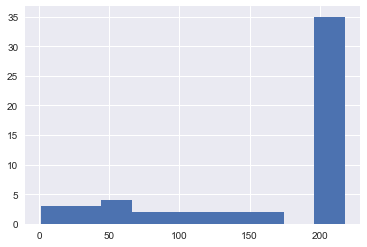

In [17]:
(ratings_matrix.R_ui > 0).sum(axis=1).hist()

In [18]:
np.percentile((ratings_matrix.R_ui > 0).sum(axis=1), 25)

111.5

In [19]:
more_than_50_ratings_mask = (ratings_matrix.R_ui > 0).sum(axis=1) > 50

In [20]:
FRACTION_TO_DROP = .2
TRAINING_MATRIX = ratings_matrix
VALIDATION_MATRIX = deepcopy(TRAINING_MATRIX)
VALIDATION_MATRIX.R_ui = pd.DataFrame(0., index=TRAINING_MATRIX.R_ui.index, columns=TRAINING_MATRIX.R_ui.columns)

for country_id, ratings in TRAINING_MATRIX.R_ui[more_than_50_ratings_mask].iterrows():
    rated_songs_mask = TRAINING_MATRIX.R_ui.ix[country_id] > 0
    rated_songs = TRAINING_MATRIX.R_ui.ix[country_id][rated_songs_mask].index.tolist()
    nb_songs_to_drop = int( len(rated_songs)*FRACTION_TO_DROP )
    songs_to_drop = set( random.sample(rated_songs, nb_songs_to_drop) )
    
    VALIDATION_MATRIX.R_ui.ix[country_id][songs_to_drop] = TRAINING_MATRIX.R_ui.ix[country_id][songs_to_drop]
    TRAINING_MATRIX.R_ui.ix[country_id][songs_to_drop] = 0.

# evaluate

In [ ]:
class ExpectedPercentileRankingsEvaluator:
    
    def __init__(self, training_matrix, validation_matrix, predicted_preferences):
        self.training_matrix = training_matrix
        self.validation_matrix = validation_matrix
        self.predicted_preferences = predicted_preferences
        self.expected_percentile_rankings_train = []
        self.expected_percentile_rankings_validation = []
        
    def run(self):
        self._evaluate_train()
        self._evaluate_validation()

    def _evaluate_train(self):
        self.expected_percentile_rankings_train = self._evaluate(matrix=self.training_matrix)
        
    def _evaluate_validation(self):
        self.expected_percentile_rankings_validation = self._evaluate(matrix=self.validation_matrix)
        
    def _evaluate(self, matrix):
        expected_percentile_rankings = []
        for country_id, preferences in self.predicted_preferences[more_than_50_ratings_mask].iterrows():
            predictions = pd.DataFrame({
                'predicted_preference': preferences.sort_values(ascending=False),
                'rank': np.arange( len(preferences) ),
                'percentile_rank': np.arange( len(preferences) ) / len(preferences)
            })
            ground_truth = matrix.R_ui.ix[country_id][ matrix.R_ui.ix[country_id] > 0 ]
            numerator = (ground_truth * predictions['percentile_rank'][ground_truth.index]).sum()
            denominator = ground_truth.sum()
            expected_percentile_rankings.append( numerator / denominator )

        return expected_percentile_rankings
    
# with a list of expected ranking values, we could compute the entropy in this distribution

In [111]:
# let's make a visualization out of this eventually

grid_search_results = {result(alpha=0.1, lmbda=0.1): {'train': 0.032407390666058453,
  
'validation': 0.31665039472192003},
 result(alpha=0.1, lmbda=1.0): {
'train': 0.032059217808275829,
  
'validation': 0.24402526519871739},
 result(alpha=0.1, lmbda=10.0): {
'train': 0.045523277235144662,
  
'validation': 0.16606585548569086},
 result(alpha=0.1, lmbda=100.0): {
'train': 0.13769244526151611,
  
'validation': 0.21052119237046174},
 result(alpha=1.0, lmbda=0.1): {
'train': 0.031713329010977634,
  
'validation': 0.28160772806600787},
 result(alpha=1.0, lmbda=1.0): {
'train': 0.031724480161575093,
  
'validation': 0.26509705526720212},
 result(alpha=1.0, lmbda=10.0): {
'train': 0.032602322510421271,
  
'validation': 0.17842803591797687},
 result(alpha=1.0, lmbda=100.0): {
'train': 0.13826569594315918,
  
'validation': 0.21545848705024651},
 result(alpha=10.0, lmbda=0.1): {
'train': 0.031434247195100157,
  
'validation': 0.2039108951054108},
 result(alpha=10.0, lmbda=1.0): {
'train': 0.031299578843675971,
  
'validation': 0.2277074749329171},
 result(alpha=10.0, lmbda=10.0): {
'train': 0.031127684231213384,
  
'validation': 0.1898255168476902},
 result(alpha=10.0, lmbda=100.0): {
'train': 0.051315700721965694,
  
'validation': 0.18669700464271369},
 result(alpha=100.0, lmbda=0.1): {
'train': 0.032712876751746674,
  
'validation': 0.18575014195665038},
 result(alpha=100.0, lmbda=1.0): {
'train': 0.032677287037866626,
  
'validation': 0.19425985589739683},
 result(alpha=100.0, lmbda=10.0): {
'train': 0.031940565004912803,
  
'validation': 0.20191916342002017},
 result(alpha=100.0, lmbda=100.0): {
'train': 0.032361700905882793,
  
'validation': 0.18102583299733102}}

In [110]:
F = 30
grid_search_results = {}
result = namedtuple('Result', 'alpha lmbda')

# for alpha in [1e-1, 1e0, 1e1, 1e2]:
#     for lmbda in [1e-1, 1e0, 1e1, 1e2]:
#         implicit_mf = ImplicitMF(ratings_matrix=TRAINING_MATRIX, f=F, alpha=alpha, lmbda=lmbda)
#         implicit_mf.run()
#         predicted_preferences = implicit_mf.country_vectors.vectors.dot( implicit_mf.song_vectors.vectors.T )
        
#         evaluator = ExpectedPercentileRankingsEvaluator(
#             training_matrix=TRAINING_MATRIX,
#             validation_matrix=VALIDATION_MATRIX,
#             predicted_preferences=predicted_preferences
#         )
#         evaluator.run()
#         grid_search_results[result(alpha=alpha, lmbda=lmbda)] = {
#             'train': np.mean(evaluator.expected_percentile_rankings_train),
#             'validation': np.mean(evaluator.expected_percentile_rankings_validation)
#         }
#         print(grid_search_results)

In [112]:
best_params = min(grid_search_results, key=lambda key: grid_search_results.get(key)['validation'])

In [ ]:
# train a final model

In [352]:
ratings_matrix = RatingsMatrix(n_top_songs=1000000, eps=1e3)

In [353]:
ratings_matrix.R_ui.shape

(55, 8662)

In [354]:
# try "best_params.alpha, lmbda here"

implicit_mf = ImplicitMF(ratings_matrix=ratings_matrix, f=F, alpha=1, lmbda=25)
implicit_mf.run()

0
1
2
3
4
5
6
7
8
9


# save stuff we care about from the final implicit mf run

In [355]:
# implicit_mf.country_vectors.vectors.to_csv('data/country_vectors.csv')
# implicit_mf.song_vectors.vectors.to_csv('data/song_vectors.csv')
# implicit_mf.country_vectors.vectors = pd.read_csv('data/country_vectors.csv', index_col=['country_id'])
# implicit_mf.song_vectors.vectors = pd.read_csv('data/song_vectors.csv', index_col=['song_id'])

## Visualize

In [356]:
country_vectors_df = implicit_mf.country_vectors.vectors

In [357]:
# change countries index form id to name

In [358]:
sns.set(style="white")

In [359]:
country_id_to_name = {countries_lookup[name]['id']: name for name in countries_lookup}
country_ids = country_vectors_df.index
country_names = pd.Index([country_id_to_name[c_id] for c_id in country_ids], name='country_name')
country_vectors_df.index = country_names

In [360]:
def plot_cosine_similarities(country_vectors_df):

    # compute the cosine similarity matrix
    similarities_df = pd.DataFrame(
        data=cosine_similarity(country_vectors_df),
        index=country_vectors_df.index,
        columns=country_vectors_df.index
    )
    
    # generate a mask for the upper triangle
    mask = np.zeros_like(similarities_df, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    # set up the matplotlib figure
    f, ax = plt.subplots(figsize=(21, 21))

    # generate a custom diverging colormap
    cmap = sns.diverging_palette(220, 10, as_cmap=True)

    # draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(similarities_df, mask=mask, cmap=cmap, vmax=.5,
                square=True, xticklabels=True, yticklabels=True,
                linewidths=1, cbar_kws={"shrink": .5}, ax=ax)

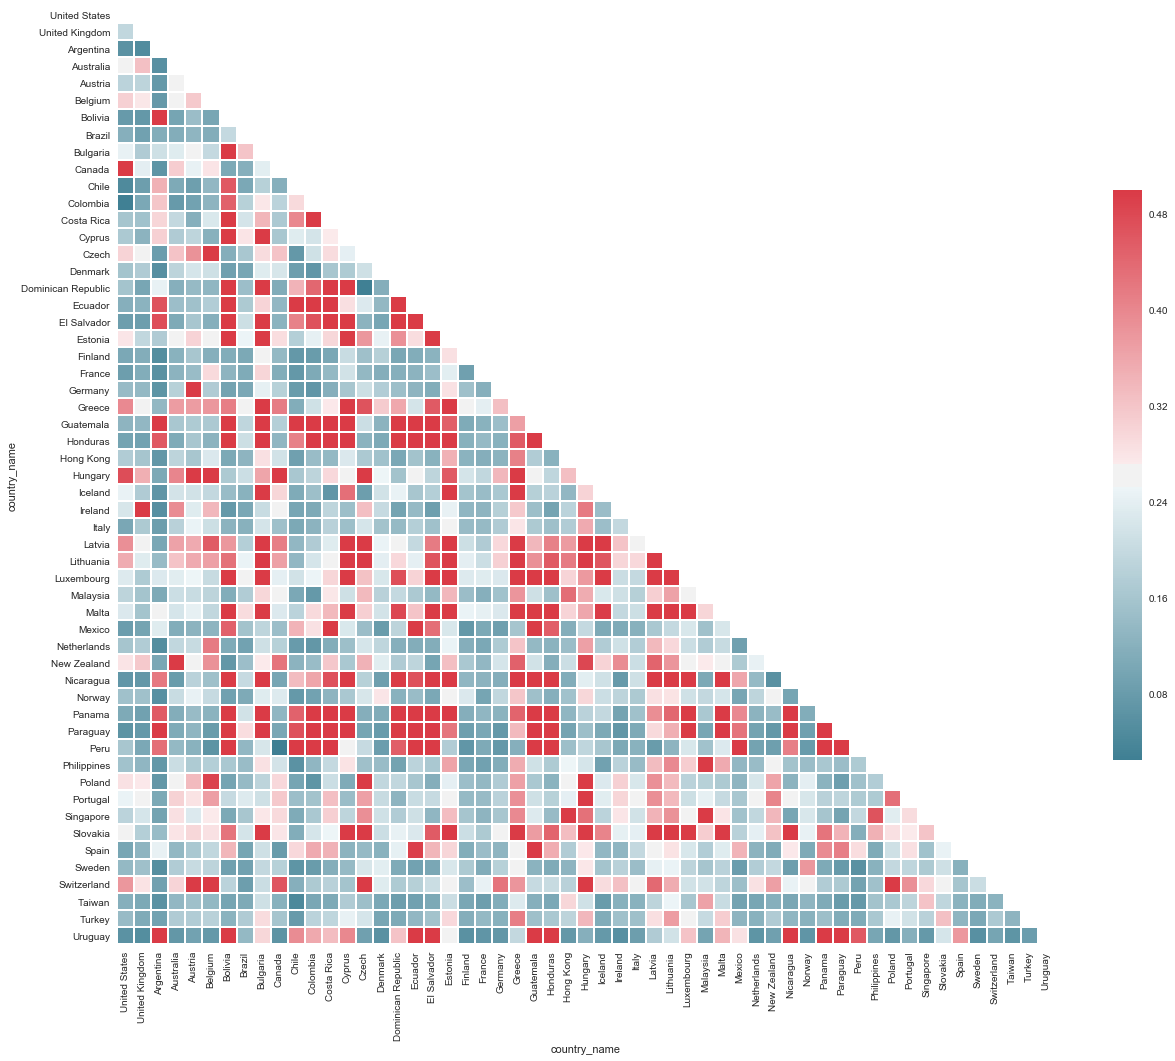

In [361]:
plot_cosine_similarities(country_vectors_df)

# tsne

In [362]:
from matplotlib import pylab
from sklearn.manifold import TSNE

In [363]:
tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)

In [364]:
country_embeddings = pd.DataFrame(
    data=tsne.fit_transform(country_vectors_df),
    index=country_vectors_df.index,
    columns=['dim_1', 'dim_2']
)

In [365]:
def plot_tsne_embeddings(country_embeddings):

    pylab.figure(figsize=(15,15))

    for country_name, country_embedding in country_embeddings.iterrows():
        dim_1, dim_2 = country_embedding
        pylab.scatter(dim_1, dim_2)
        pylab.annotate(country_name, xy=(dim_1, dim_2), xytext=(5, 2), textcoords='offset points',
                   ha='right', va='bottom')
    pylab.show()

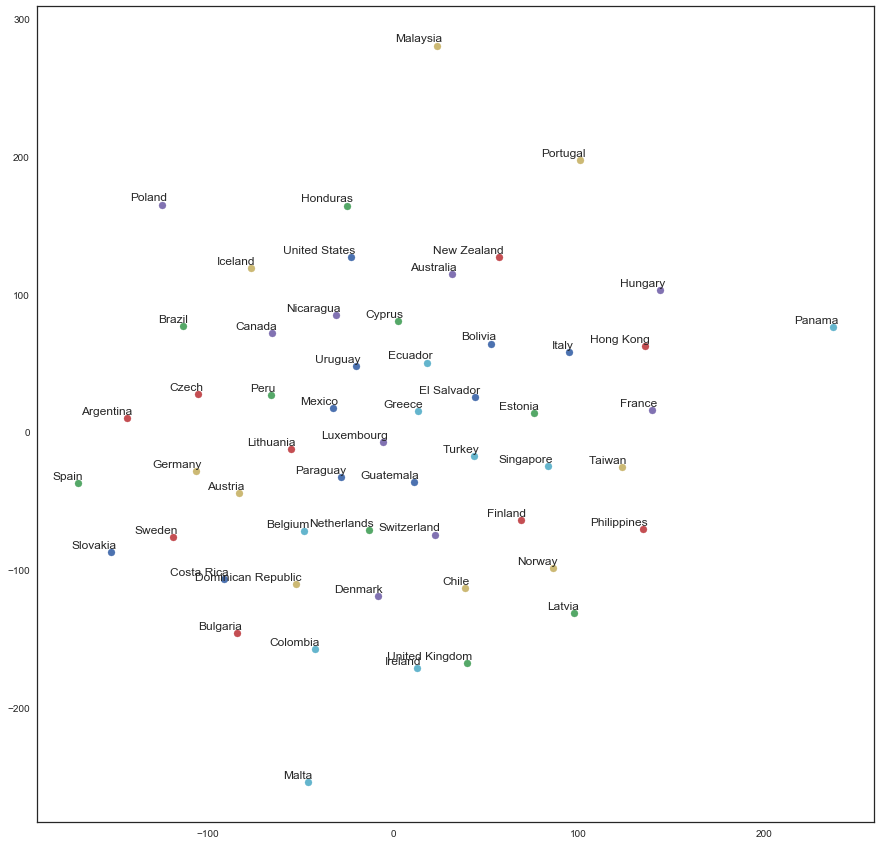

In [366]:
plot_tsne_embeddings(country_embeddings)

## Inspect arithmetic combinations

In [278]:
SONG_METADATA_QUERY = """
    SELECT 
        songs.title as song_title, 
        songs.artist as song_artist,
        songs.id as song_id
    FROM songs
"""

song_metadata_df = pd.read_sql(SONG_METADATA_QUERY, ENGINE, index_col=['song_id'])

In [367]:
song_vectors_df = song_metadata_df.join(implicit_mf.song_vectors.vectors, how='inner')\
    .set_index(['song_title', 'song_artist'])

In [368]:
song_vectors_df = song_vectors_df.apply(lambda vec: vec / np.linalg.norm(vec), axis = 1)
# normalize all country vectors here

In [369]:
country_vec = country_vectors_df.ix['United States'] / np.linalg.norm(country_vectors_df.ix['United States'])

In [370]:
pd.set_option('display.max_colwidth', 100)

In [371]:
song_vectors_df.dot(country_vec).sort_values(ascending=False).reset_index().head(10)

,song_title,song_artist,0
0,Up On The Housetop,Pentatonix,0.942842
1,Hurricane,Luke Combs,0.929649
2,My Shit,A Boogie Wit da Hoodie,0.929649
3,Drugs,August Alsina,0.929649
4,In Case You Didn't Know,Brett Young,0.929649
5,Flip,Future,0.929649
6,For Free,DJ Khaled,0.929649
7,F*ck Up Some Commas,Future,0.929649
8,Do What I Want,Lil Uzi Vert,0.929649
9,Frequency,Kid Cudi,0.929649


In [372]:
country_vec = country_vectors_df.ix['Colombia'] / np.linalg.norm(country_vectors_df.ix['Colombia'])
# country_vec = country_vectors_df.ix['Colombia']

In [373]:
song_vectors_df.dot(country_vec).sort_values(ascending=False).reset_index().head(10)

,song_title,song_artist,0
0,Ya No Me Duele Más,Silvestre Dangond,0.948051
1,Bajo el agua,Manuel Medrano,0.942612
2,Déjame Te Explico,Reykon,0.938890
3,Mil Lágrimas,Nicky Jam,0.937492
4,"Oiga, Mira, Vea",Guayacán Orquesta,0.937037
5,El Ganador,Nicky Jam,0.936902
6,Quédate,Manuel Medrano,0.936452
7,Afuera del planeta,Manuel Medrano,0.933912
8,Materialista,Silvestre Dangond,0.933106
9,La rebelion,Joe Arroyo,0.932525


In [384]:
country_vec = country_vectors_df.ix['Germany'] / np.linalg.norm(country_vectors_df.ix['Germany'])
# country_vec = country_vectors_df.ix['Panama']

In [385]:
song_vectors_df.dot(country_vec).sort_values(ascending=False).reset_index().head(10)

,song_title,song_artist,0
0,Skandale,Bonez MC,0.958880
1,Tote Präsidenten,Genetikk,0.958784
2,Apocalyptic Infinty,SpongeBozz,0.958741
3,Dein Lied,Kraftklub,0.958689
4,Apocalyptic Infinty - Payback #forsundiego Version,SpongeBozz,0.958645
5,Wolkenkratzer,Gary Washington,0.958528
6,I Want It That Way - Anstandslos & Durchgeknallt Remix,Backstreet Boys,0.958463
7,Half Of Me,Tom Bleasby,0.958434
8,No Ordinary,Alle Farben,0.958428
9,Leichtsinn,Tim Bendzko,0.958428


# hit it with the neural network

In [70]:
from itertools import product

from keras import backend as K
from keras.layers import Input, Embedding, Flatten, Lambda, Dense, BatchNormalization, Dropout
from keras.layers.merge import add, dot, concatenate
from keras.models import Model
from keras.optimizers import Adam
from keras.regularizers import l2

In [22]:
alpha = 1
lmbda = 25
F = 30
LEARNING_RATE = .001

In [23]:
n_countries, n_songs = ratings_matrix.R_ui.shape

In [24]:
P_ui = TRAINING_MATRIX.R_ui > 0
C_ui = 1 + alpha*TRAINING_MATRIX.R_ui

In [25]:
def implicit_cf_loss(y_true, y_pred, alpha=alpha):
    P = y_true > 0
    C = 1 + alpha*y_true
    return K.mean( C*(P - y_pred)**2 )

In [26]:
country_id_to_index = {c_id: index for index, c_id in enumerate(ratings_matrix.R_ui.index)}
song_id_to_index = {s_id: index for index, s_id in enumerate(ratings_matrix.R_ui.columns)}

In [28]:
def prepare_data_for_training(training_df):
    input_tuples = list( product(training_df.index, training_df.columns) )
    country_ids, song_ids = zip(*input_tuples)
    country_ids = [country_id_to_index[country_id] for country_id in country_ids]
    song_ids = [song_id_to_index[song_id] for song_id in song_ids]
    return np.array(country_ids), np.array(song_ids), training_df.values.flatten()

In [29]:
country_ids_train, song_ids_train, ratings_train = prepare_data_for_training(TRAINING_MATRIX.R_ui)
country_ids_validation, song_ids_validation, ratings_validation = prepare_data_for_training(VALIDATION_MATRIX.R_ui)

# first model

In [27]:
country_input = Input(shape=(1,), dtype='int64', name='country')
country_embedding = Embedding(input_dim=n_countries, output_dim=F, embeddings_regularizer=l2(lmbda))(country_input)

song_input = Input(shape=(1,), dtype='int64', name='song')
song_embedding = Embedding(input_dim=n_songs, output_dim=F, embeddings_regularizer=l2(lmbda))(song_input)

predicted_preference = dot(inputs=[country_embedding, song_embedding], axes=2)
predicted_preference = Flatten()(predicted_preference)

In [43]:
model = Model(inputs=[country_input, song_input], outputs=predicted_preference)
model.compile(loss=implicit_cf_loss, optimizer=Adam(lr=LEARNING_RATE))

In [46]:
model.fit(
    x=[country_ids_train, song_ids_train],
    y=ratings_train,
    batch_size=256, 
    epochs=5,
    validation_data=([country_ids_validation, song_ids_validation], ratings_validation)
)

Train on 117150 samples, validate on 117150 samples
Epoch 1/5
117150/117150 [==============================] - 0s - loss: 41.8865 - val_loss: 0.0510

In [51]:
country_bias = Embedding(input_dim=n_countries, output_dim=1, name='country_bias', input_length=1)(country_input)
song_bias = Embedding(input_dim=n_songs, output_dim=1, name='song_bias', input_length=1)(song_input)

country_bias = Flatten()(country_bias)
song_bias = Flatten()(song_bias)

predicted_preference = add(inputs=[predicted_preference, country_bias])
predicted_preference = add(inputs=[predicted_preference, song_bias])

In [52]:
model = Model(inputs=[country_input, song_input], outputs=predicted_preference)
model.compile(loss=implicit_cf_loss, optimizer=Adam(lr=LEARNING_RATE))

In [53]:
model.fit(
    x=[country_ids_train, song_ids_train],
    y=ratings_train,
    batch_size=256, 
    epochs=10,
    validation_data=([country_ids_validation, song_ids_validation], ratings_validation)
)

/Users/willwolf/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Train on 117150 samples, validate on 117150 samples
Epoch 1/10
117150/117150 [==============================] - 0s - loss: 41.6005 - val_loss: 0.0483

# the full model with biases and more layers

In [ ]:
a = Input((10, 5))  # batch_size, 10, 5
b = Input((5,))  # batch_size, 5
c = add([a, b])  # batch_size, 10, 5
model = Model([a, b], c)

In [92]:
country_input = Input(shape=(1,), dtype='int64', name='country')
song_input = Input(shape=(1,), dtype='int64', name='song')

country_embedding = Embedding(input_dim=n_countries, output_dim=F, embeddings_regularizer=l2(lmbda))(country_input)
song_embedding = Embedding(input_dim=n_songs, output_dim=F, embeddings_regularizer=l2(lmbda))(song_input)

country_bias = Embedding(input_dim=n_countries, output_dim=1, name='country_bias', input_length=1)(country_input)
song_bias = Embedding(input_dim=n_songs, output_dim=1, name='song_bias', input_length=1)(song_input)

concatenation = concatenate([country_embedding, song_embedding])

dense_layer = Dense(activation='relu', units=10)(concatenation)
dropout = Dropout(.5)(dense_layer)
batch_norm = BatchNormalization()(dropout)
dense_layer = Dense(activation='relu', units=10)(batch_norm)
batch_norm = BatchNormalization()(dense_layer)
dense_layer = Dense(activation='relu', units=10)(batch_norm)
batch_norm = BatchNormalization()(dense_layer)

predicted_preference = Dense(units=1, name='predicted_preference')(batch_norm)
predicted_preference = Flatten()(predicted_preference)

country_bias = Flatten()(country_bias)
song_bias = Flatten()(song_bias)

predicted_preference = add(inputs=[predicted_preference, country_bias])
predicted_preference = add(inputs=[predicted_preference, song_bias])

In [93]:
model = Model(inputs=[country_input, song_input], outputs=predicted_preference)
model.compile(loss=implicit_cf_loss, optimizer=Adam(lr=LEARNING_RATE))

In [75]:
model.optimizer.lr.set_value(.0001)

In [94]:
model.fit(
    x=[country_ids_train, song_ids_train],
    y=ratings_train,
    batch_size=256, 
    epochs=10,
    validation_data=([country_ids_validation, song_ids_validation], ratings_validation)
)

Train on 117150 samples, validate on 117150 samples
Epoch 1/10
117150/117150 [==============================] - 2s - loss: 41.6033 - val_loss: 0.0980